In [1]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE, Predictive_adversarial
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
from ddganAE.preprocessing import convert_2d
from keras.regularizers import l2
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# POD coefficients prediction

## Preprocessing and POD

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [3]:
grids.shape

(8000, 60, 20, 20, 4)

In [ ]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = grids[:,:,:,:,:3] - np.mean(grids[:,:,:,:,:3])
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [ ]:
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
grids_long = np.moveaxis(grids_reshaped, 1, 5).reshape((grids_reshaped.shape[0], -1, grids_reshaped.shape[1]))
grids_long = np.swapaxes(grids_long, 0, 2)

In [6]:
nPOD = 10
coeffs, R, s = calc_pod(grids_long, nPOD=nPOD)

SSmatrix (8000, 8000)


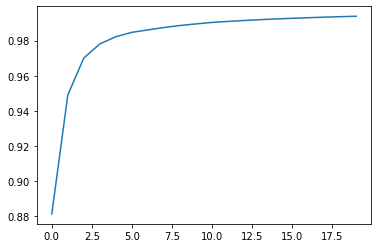

In [7]:
plt.plot(np.cumsum(s**2/sum(s**2))[:20])

In [8]:
train_data = np.array(coeffs)[:4]
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))\
    .reshape(train_data.shape)

In [9]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = np.dot(R.T, grids_long[0])
boundaries[1] = np.dot(R.T, grids_long[3])

init_values = np.zeros((2, 10))
init_values[0] = np.dot(R.T, grids_long[1])[:, 0]
init_values[1] = np.dot(R.T, grids_long[2])[:, 0]

boundaries = scaler.transform(boundaries.reshape(-1, 1)).reshape(boundaries.shape)

init_values = scaler.transform(init_values.reshape(-1, 1)).reshape(init_values.shape)

## Running model 

In [10]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 15
nPOD = 10

encoder = build_dense_encoder(
    vars_latent,
    initializer,
    info=False,
    act="elu",
    dropout=0.8,
)
decoder = build_dense_decoder(
    nPOD,
    vars_latent,
    initializer,
    act="elu",
    dropout=0.8,
)
discriminator = build_custom_discriminator(
    vars_latent, initializer, info=False
)

In [11]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)
pred_adv.train(
    train_data,
    2000,
    batch_size=64,
    wandb_log=False,
)

In [ ]:
predicted = pred_adv.predict(boundaries, init_values, 100)

In [ ]:
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(predicted.shape)

In [ ]:
plt.plot(predicted[1, :10, :150].reshape(-1, 100).T)

In [49]:
real = np.dot(R.T, grids_long[1])[:, ::5][:, 1:]

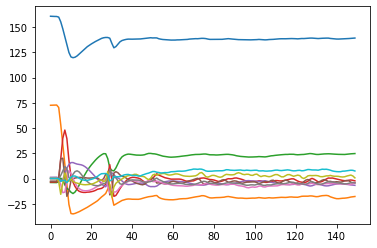

In [50]:
plt.plot(real[:10, :150].reshape(-1, 150).T)

# Latent variable prediction

## Preprocessing and generating latent variables

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [3]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.98, beta_2=0.9)

input_shape = (60, 20, 20, 4)

encoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_different-sweep-1/encoder") 
decoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_different-sweep-1/decoder")

In [5]:
cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

In [6]:
latent_vars = cae.encoder.predict(grids)

In [7]:
latent_vars.shape

(8000, 10)

In [8]:
latent_vars_reshaped = np.moveaxis(latent_vars.reshape(800, 10, 10), 0, 2)
latent_vars_reshaped.shape

(10, 10, 800)

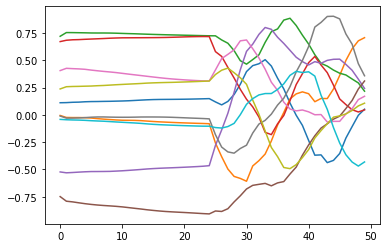

In [9]:
plt.plot(latent_vars_reshaped[1, :, :50].T)

In [10]:
# No need for transformations as these are already rescaled, grab the first four latent variables
train_data = latent_vars_reshaped[:4]

In [11]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[0]
boundaries[1] = train_data[3]

init_values = np.zeros((2, 10))
init_values[0] = train_data[1][:, 0]
init_values[1] = train_data[2][:, 0]

## Running model 

In [12]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 30
nPOD = 10

In [13]:
encoder, decoder = build_vinicius_encoder_decoder(nPOD, vars_latent, initializer, dropout=0.6, reg=0)

In [14]:
#encoder = build_dense_encoder(vars_latent,initializer,info=False,act="elu",dropout=0.8)
#decoder = build_dense_decoder(nPOD, vars_latent, initializer, act="elu",dropout=0.8)
discriminator = build_custom_discriminator(vars_latent, initializer, info=False)

In [15]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)
pred_adv.train(
    train_data,
    2000,
    interval=10,
    batch_size=64,
    wandb_log=False,
)

KeyboardInterrupt: 

In [16]:
predicted = pred_adv.predict(boundaries, init_values, 50, iters=6)

In [17]:
predicted.shape

(4, 10, 79)

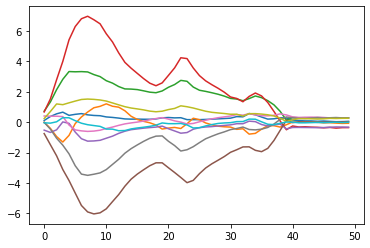

In [27]:
plt.plot(predicted[1, :, :50].T)

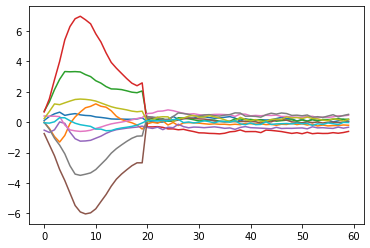

In [26]:
train_data_int = train_data[:, :, ::10]
plt.plot(train_data_int[1, :, :60].T)

In [20]:
#out = latent_vars_reshaped[:, :, ::5][:,:,:100]
out = latent_vars_reshaped[:, :, ::10][:, :, :20]
out[1] = predicted[1, :,:20]
out[2] = predicted[2, :,:20]

In [21]:
out_reshaped = np.moveaxis(out, 2, 0).reshape(200, 10)

In [22]:
out_grids = cae.decoder.predict(out_reshaped)
out_grids[:,:,:,:,:3] = scaler.inverse_transform(out_grids[:,:,:,:,:3].reshape(-1, 1)).reshape(out_grids[:,:,:,:,:3].shape)

In [23]:
np.save("out_grids.npy", out_grids)